# Deep Learning for Cone Cells and Light Frequency

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

np.set_printoptions(suppress=True)

import sklearn.metrics as metrics

import tensorflow as tf
from tensorflow import keras

import pickle

from simulator_lib import *

2025-04-24 22:52:44.063185: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-24 22:52:44.095615: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-24 22:52:44.113952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745549564.136990    4891 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745549564.144534    4891 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-24 22:52:44.175930: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## Generating / Loading the Cone Cells

In [ ]:
GENERATE_NEW_CONE_CELLS = False

NUM_EYES = 10
NUM_CELLS_PER_EYE = 10000

NUM_RED = int(NUM_CELLS_PER_EYE * PERCENT_RED)
NUM_GREEN = int(NUM_CELLS_PER_EYE * PERCENT_GREEN)
NUM_BLUE = int(NUM_CELLS_PER_EYE * PERCENT_BLUE)
assert(NUM_RED + NUM_GREEN + NUM_BLUE == NUM_CELLS_PER_EYE)

if GENERATE_NEW_CONE_CELLS:

    eyes = []

    for i in range(NUM_EYES):
        RED_MU = np.random.uniform(RED_MU_LOWER, RED_MU_UPPER)
        GREEN_MU = np.random.uniform(GREEN_MU_LOWER, GREEN_MU_UPPER)
        BLUE_MU = np.random.uniform(BLUE_MU_LOWER, BLUE_MU_UPPER)

        # create the cone cells
        cone_cells = (
            generate_cone_cells(NUM_RED, RED_MU, RED_SIGMA) +
            generate_cone_cells(NUM_GREEN, GREEN_MU, GREEN_SIGMA) +
            generate_cone_cells(NUM_BLUE, BLUE_MU, BLUE_SIGMA)
        )
        # shuffle the cone cells around
        np.random.shuffle(cone_cells)

        eyes.append(cone_cells)

        # save the cone cells
        with open(f"./data/normal_cone_cells/eye{i:02}.pkl", "wb") as fp:
            pickle.dump(cone_cells, fp, pickle.HIGHEST_PROTOCOL)

else:

    eyes = []

    for i in range(NUM_EYES):
        with open(f"./data/normal_cone_cells/eye{i:02}.pkl", mode="rb") as fp:
            cone_cells = pickle.load(fp)
            eyes.append(cone_cells)

print(len(eyes))
print(eyes)

10
[[<simulator_lib.ConeCell object at 0x735a5026b5c0>, <simulator_lib.ConeCell object at 0x735a4fee39b0>, <simulator_lib.ConeCell object at 0x735a4fee1b50>, <simulator_lib.ConeCell object at 0x735a4fee00e0>, <simulator_lib.ConeCell object at 0x735a4fee1c10>, <simulator_lib.ConeCell object at 0x735a4fee22a0>, <simulator_lib.ConeCell object at 0x735a4fee1d30>, <simulator_lib.ConeCell object at 0x735a4fee2bd0>, <simulator_lib.ConeCell object at 0x735a4fee3680>, <simulator_lib.ConeCell object at 0x735a4fee0e90>, <simulator_lib.ConeCell object at 0x735a4fee3980>, <simulator_lib.ConeCell object at 0x735a4fee1970>, <simulator_lib.ConeCell object at 0x735a4fee03b0>, <simulator_lib.ConeCell object at 0x735a4fee0170>, <simulator_lib.ConeCell object at 0x735a4fee1c70>, <simulator_lib.ConeCell object at 0x735a4fee0bc0>, <simulator_lib.ConeCell object at 0x735a4fee0440>, <simulator_lib.ConeCell object at 0x735a4fee13a0>, <simulator_lib.ConeCell object at 0x735a4fee3710>, <simulator_lib.ConeCell ob

## Generating the Simulation Data

In [21]:
NUM_DATA_POINTS = 1000
MIN_WAVELENGTH = 380
MAX_WAVELENGTH = 750

activations = np.zeros(shape=(len(eyes) * NUM_DATA_POINTS, len(eyes[0])))
colors = np.zeros(shape=(len(eyes) * NUM_DATA_POINTS))

for i, cone_cells in enumerate(eyes):
    a, c = sample_wavelengths(
        num_data_points=NUM_DATA_POINTS, 
        cells=cone_cells, 
        min_wl=MIN_WAVELENGTH, 
        max_wl=MAX_WAVELENGTH,
    )
    c = np.array(c).astype(int)

    activations[i * NUM_DATA_POINTS : (i+1) * NUM_DATA_POINTS] = a
    colors[i * NUM_DATA_POINTS : (i+1) * NUM_DATA_POINTS] = c

print(activations)
print(colors)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 2. 5. ... 0. 0. 0.]


## Feedforward Network Architecture

### Separate Data into Training and Test Sets

In [22]:
# shuffle the data
randomize = np.arange(len(activations), dtype=int)
np.random.shuffle(randomize)
activations = activations[randomize]
colors = colors[randomize]

PERCENT_TRAIN_SET = 0.85
NUM_TRAIN_SET = int(len(activations) * PERCENT_TRAIN_SET)

train_activations = activations[:NUM_TRAIN_SET]
train_colors = colors[:NUM_TRAIN_SET]
test_activations = activations[NUM_TRAIN_SET:]
test_colors = colors[NUM_TRAIN_SET:]

### Model Setup

In [23]:
model = keras.Sequential([
    keras.Input(shape=(train_activations.shape[-1], )),
    keras.layers.Dense(units=128, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=128, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=128, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=128, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=len(Color), activation="softmax"),
])

2025-04-24 23:10:19.264179: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Compile Model

In [24]:
optimizer = keras.optimizers.AdamW(learning_rate=5e-4, weight_decay=0.004)
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │     1,280,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,330,438 (5.08 MB)

 Trainable params: 1,330,438 (5.08 MB)

 Non-trainable params: 0 (0.00 B)

### Fit the Model

In [25]:
EPOCHS = 10
h = model.fit(train_activations, train_colors, batch_size=64, epochs=EPOCHS, validation_split=0.1)

Epoch 1/10


2025-04-24 23:10:26.176776: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 306000000 exceeds 10% of free system memory.


120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.7670 - loss: 0.9668 - val_accuracy: 0.9788 - val_loss: 0.0889
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9598 - loss: 0.1367 - val_accuracy: 0.9776 - val_loss: 0.0539
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9725 - loss: 0.0872 - val_accuracy: 0.9835 - val_loss: 0.0450
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9746 - loss: 0.0721 - val_accuracy: 0.9882 - val_loss: 0.0317
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9805 - loss: 0.0563 - val_accuracy: 0.9812 - val_loss: 0.0561
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9849 - loss: 0.0490 - val_accuracy: 0.9800 - val_loss: 0.0588
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9817 - loss: 0.0541 - val_accuracy: 0.9812 - val_loss: 0.0391
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9889 - loss: 0.0377 - val_accuracy: 0.990

### Visualize Loss Trajectory

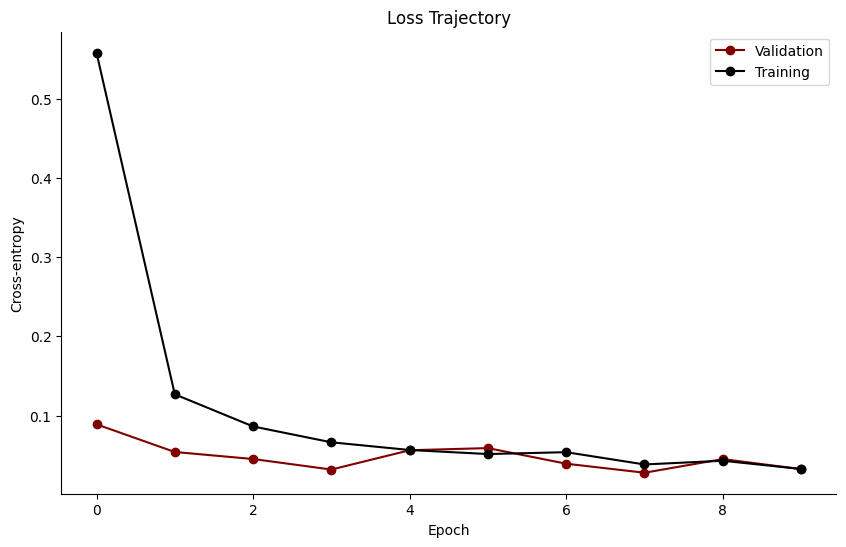

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(range(EPOCHS), h.history['val_loss'], 'o-', color='maroon', label='Validation')
ax.plot(range(EPOCHS), h.history['loss'], 'o-', color='black', label='Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross-entropy')
ax.legend()
ax.set_title('Loss Trajectory')
sns.despine(ax=ax)

### Evaluate Model on Test Data

In [27]:
test_loss, test_accuracy = model.evaluate(test_activations, test_colors)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9855 - loss: 0.0242


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


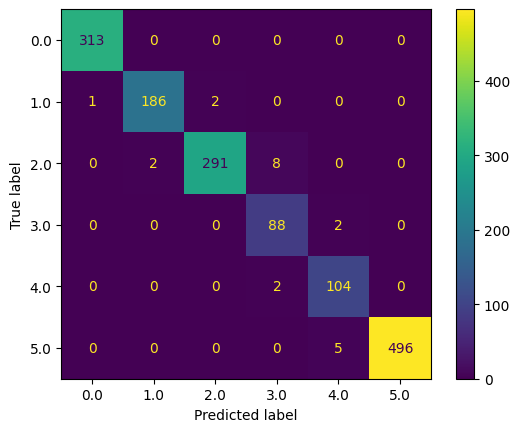

In [28]:
preds = model.predict(test_activations)
metrics.ConfusionMatrixDisplay.from_predictions(test_colors, preds.argmax(axis=1))